# Visualizing the HIV/AIDS Epidemic Over Time

For this assignment, I'm aiming to visualize various metrics related to the HIV/AIDS epidemic and observing related trends. Overall, I'm interested in observing how our treatment of this epidemic has changed over time and by country, and any underlying economic/development indicators that may be correlated with these discrepancies.

The primary data I'm using in this notebook comes from the 2019 Global Burden of Disease (GBD) study. Citation:

> Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 (GBD 2019) Results. Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2021.

This study includes comprehensive data on death rates, risk factors, etc, for all illnesses (not just HIV/AIDS but other STIs, cancers, lung diseases, pretty much all medical causes), sorted by age group, sex, and time. I've selected just the data for HIV/AIDS for the sake of this illustration.

I retrieved all of the data from their [data tool](http://ghdx.healthdata.org/gbd-results-tool), which makes their data available for non-commercial use according to their [user agreement](https://www.healthdata.org/about/ihme-free-charge-non-commercial-user-agreement).

#### Parameters used for data dump

* **Measure**: `Deaths`, `Incidence`
* **Metric**: `Number`, `Percent`, `Rate`
* **Cause**: `HIV/AIDS`
* **Location**: all countries
* **Age**: `<1 year`, `1-4 years`, `5-9 years` ... `90-94 years`, `95+ years`
* **Sex**: `Male`, `Female`
* **Year**: `1990`, `1991`, `1992` ... `2019`


## Importing and tidying data

The data from my dump is so large that it was provided in 4 individual files with identical schemas. First, I'll import them individually and then use [`pandas.concat()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html) to combine them into one large CSV.

This first codeblock may take some time to run depending on your Internet connection.

In [118]:
import pandas as pd

base_url = 'https://raw.githubusercontent.com/justsharan/notebooks/main/hiv-analysis/'

hiv_aids_1 = pd.read_csv(base_url + 'IHME-GBD_2019_DATA-12384556-1.csv')
hiv_aids_2 = pd.read_csv(base_url + 'IHME-GBD_2019_DATA-12384556-2.csv')
hiv_aids_3 = pd.read_csv(base_url + 'IHME-GBD_2019_DATA-12384556-3.csv')
hiv_aids_4 = pd.read_csv(base_url + 'IHME-GBD_2019_DATA-12384556-4.csv')

hiv_aids = pd.concat([hiv_aids_1, hiv_aids_2, hiv_aids_3, hiv_aids_4])
hiv_aids.head()

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower
0,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,1,Number,1990,5.316867,35.223499,0.027538
1,1,Deaths,19,Timor-Leste,2,Female,5,1-4 years,298,HIV/AIDS,1,Number,1990,5.163228,34.571189,0.024230
2,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,2,Percent,1990,0.008707,0.061109,0.000043
3,1,Deaths,19,Timor-Leste,2,Female,5,1-4 years,298,HIV/AIDS,2,Percent,1990,0.006556,0.045694,0.000031
4,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,3,Rate,1990,9.700048,64.261450,0.050241


The problem I noticed early on while playing with the GBD study dataset is that it doesn't provide a standardized identifier for the country that each observation is about. It provides proprietary `location_id` values and country names in `location_name`, which are often different from what other tools require (the libraries I'd like to use this data with). For example, it may identify Iran as "Iran (Islamic Republic of)", while other data sources will just say "Iran" or "Islamic Republic of Iran."

Hence, I'll do some merges with other dataframes to add ISO 3166-1 alpha-3 country codes (like `CAN` for Canada) as another column so that this data can be used properly with other libraries like `geopandas`.

First, I'll just extract the relevant data I need to fill in. Once I have a mapping of GBD's `location_id`'s to ISO A3 country codes, I'll merge that in with the main dataset.

In [119]:
countries = hiv_aids[['location_id', 'location_name']] \
    .drop_duplicates() \
    .set_index('location_id')

Next, I'll pull in the Wikipedia entry for the ISO 3166-1 standard, which provides a useful table that maps country names to ISO-3166-1 two and three-letter country codes. Then, I'll perform a left join on `countries` with the `wiki` dataframe below.

In [120]:
from bs4 import BeautifulSoup
import requests
import re

# Get table from wikipedia
article = requests.get('https://en.wikipedia.org/wiki/ISO_3166-1').text
soup = BeautifulSoup(article, 'lxml')

# Load the table onto pandas
wiki = pd.read_html(str(soup.find_all('table', { 'class': 'wikitable sortable' })))[0]

# Remove wikipedia references using regex
name_row = 'English short name (using title case)'
wiki[name_row] = wiki[name_row].apply(lambda s: re.sub('\[.*?\]', '', s).rstrip())

# Rename columns (if I use left_on and right_on params, we're left with two name columns)
wiki = wiki[[name_row, 'Alpha-3 code']]
wiki.columns = ['location_name', 'code']

# Left merge on countries with wiki
countries_df = countries.reset_index() \
    .merge(wiki, on='location_name', how='left', validate='1:1') \
    .set_index('location_id')
countries_df.head()

,location_name,code
location_id,,
19,Timor-Leste,TLS
35,Georgia,GEO
67,Japan,JPN
52,Romania,ROU
98,Chile,CHL


How effective was this? Does every location have a code assigned to it?

In [121]:
countries_df[countries_df['code'].isna()]

,location_name,code
location_id,,
68,Republic of Korea,NaN
149,Palestine,NaN
61,Republic of Moldova,NaN
422,United States Virgin Islands,NaN
8,Taiwan (Province of China),NaN
7,Democratic People's Republic of Korea,NaN
171,Democratic Republic of the Congo,NaN
155,Turkey,NaN
189,United Republic of Tanzania,NaN


This was expected since some countries won't be named exactly the same across both dataframes (ex. our data calls it "Republic of Korea", Wikipedia calls it "Korea, Republic of". We can just manually patch these names.

In [122]:
fixed = pd.DataFrame({
    'location_name': ['Republic of Korea', 'Republic of Moldova', 'United States Virgin Islands', 'Taiwan (Province of China)', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Turkey', 'United Republic of Tanzania', 'United Kingdom'],
    'code': ['KOR', 'MDA', 'VIR', 'TWN', 'PRK', 'COD', 'TUR', 'TZA', 'GBR']
})

# Merge the fixed dataframe
countries_df = countries_df.merge(fixed, on='location_name', how='left',
                                  validate='1:1', suffixes=('', '_f'))
countries_df['code'] = countries_df['code'].fillna(countries_df['code_f'])

# Drop fixed code column
countries_df.drop(['code_f'], axis=1, inplace=True)
countries_df

,location_name,code
0,Timor-Leste,TLS
1,Georgia,GEO
2,Japan,JPN
3,Romania,ROU
4,Chile,CHL
...,...,...
199,Equatorial Guinea,GNQ
200,United Republic of Tanzania,TZA
201,United Kingdom,GBR
202,Vanuatu,VUT


Now, I'll finally merge this onto the main `hiv_aids` dataset with forward fill to add ISO 3166-1 alpha-3 country codes to each row.

In [123]:
hiv_aids = hiv_aids.merge(countries_df, on='location_name', how='left', validate='m:1')
hiv_aids.head()

,measure_id,measure_name,location_id,location_name,sex_id,sex_name,age_id,age_name,cause_id,cause_name,metric_id,metric_name,year,val,upper,lower,code
0,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,1,Number,1990,5.316867,35.223499,0.027538,TLS
1,1,Deaths,19,Timor-Leste,2,Female,5,1-4 years,298,HIV/AIDS,1,Number,1990,5.163228,34.571189,0.024230,TLS
2,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,2,Percent,1990,0.008707,0.061109,0.000043,TLS
3,1,Deaths,19,Timor-Leste,2,Female,5,1-4 years,298,HIV/AIDS,2,Percent,1990,0.006556,0.045694,0.000031,TLS
4,1,Deaths,19,Timor-Leste,1,Male,5,1-4 years,298,HIV/AIDS,3,Rate,1990,9.700048,64.261450,0.050241,TLS


## Visualizing basic metrics

Now that all the data is properly labeled, we can try to make some basic visualizations about it. For example, here's a map of the HIV/AIDS death rate by country as of 2019.

In [124]:
import geopandas as gpd

hiv_aids_df = hiv_aids.query('metric_name == "Rate" & year == 2019 & measure_name == "Deaths"') \
    .groupby(by='code') \
    .agg({ 'val': sum, 'upper': max, 'lower': min })

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

hiv_aids_visual = world \
    .drop(['pop_est', 'gdp_md_est'], axis=1) \
    .merge(hiv_aids_df, left_on='iso_a3', right_on='code', validate='1:1')

hiv_aids_visual.explore(column='val', cmap='OrRd', scheme='Percentiles')

From the graph, it looks like most of the HIV/AIDS epidemic in 2019 was centered around Western and Sub-Saharan Africa, with some countries in Southeast Asia and South America also having disproportionately high death rates from the disease. We can take a closer look at the data for African countries.

In [125]:
african = hiv_aids_visual['continent'].eq('Africa')
hiv_aids_visual[african].explore(column='val', cmap='OrRd', scheme='Percentiles')

While this data is interesting, we can also look at the distribution of deaths by age group.

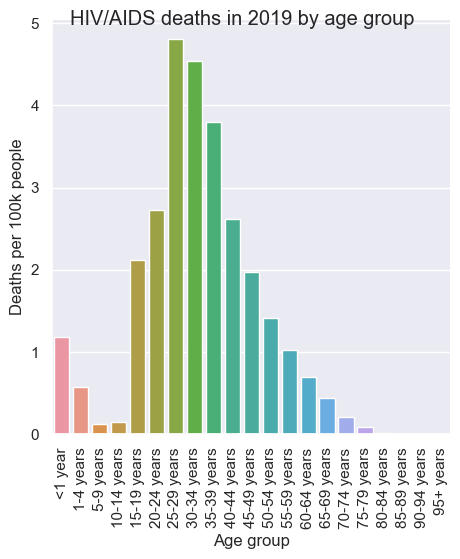

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set('notebook')

age_df = hiv_aids.query('metric_name == "Number" & year == 2019') \
    .groupby(by='age_name') \
    .agg({ 'val': np.sum }) \
    .reset_index()

# Per 100k people
age_df['val'] /= 100000

age_order = ['<1 year', '1-4 years', '5-9 years',
             '10-14 years', '15-19 years',
            '20-24 years', '25-29 years',
            '30-34 years', '35-39 years',
            '40-44 years', '45-49 years',
            '50-54 years', '55-59 years',
            '60-64 years', '65-69 years',
            '70-74 years', '75-79 years',
            '80-84 years', '85-89 years',
            '90-94 years', '95+ years']

g = sns.catplot(x='age_name', y='val', data=age_df, kind='bar', order=age_order)
g.set_xticklabels(rotation=90)
g.set(xlabel='Age group', ylabel='Deaths per 100k people')
g.fig.suptitle('HIV/AIDS deaths in 2019 by age group')

plt.show()

It looks like there is a spike of deaths in infants (<1 year) and goes down for children. By the teenage years, deaths rise again, peaking at roughly 4.8 deaths per 100k for people aged 25-29, before slowly coming back down.

## Visualizing trends over time
Since we have data split up by year from 1990-2019, we can also look at how cases and deaths have changed over time.

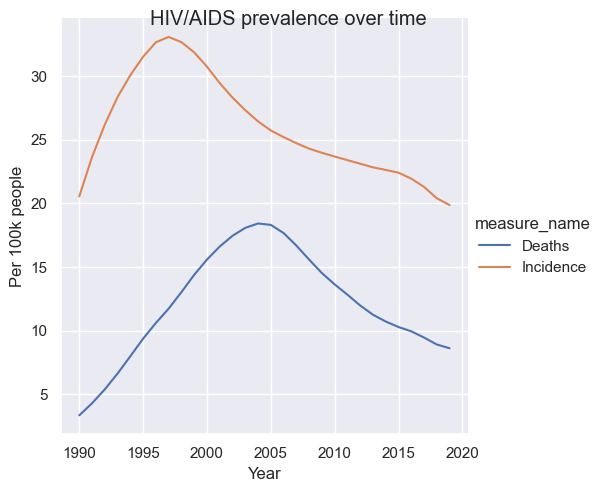

In [127]:
df = hiv_aids.query('metric_name == "Number"') \
    .groupby(by=['year', 'measure_name']) \
    .agg({ 'val': sum }) \
    .reset_index()

df['val'] /= 100000

g = sns.relplot(x='year', y='val', data=df, kind='line', hue='measure_name')
g.fig.suptitle('HIV/AIDS prevalence over time')
g.set(xlabel='Year', ylabel='Per 100k people')

plt.show()

As expected, there is a "lag" between cases and deaths, as cases take a while to affect the patient (and eventually cause death). This lag of about 10 years between the maximum value of the Deaths curve and the Incidents curve is actually consistent with the observed life expectancy for HIV/AIDS patients at the time.

> Average life expectancy after HIV diagnosis increased from 10.5 to 22.5 years from 1996 to 2005. Life expectancy (years) was better for females than for males but improved less for females (females: 12.6-23.6 and males: 9.9-22.0). In 2005, life expectancy for black males was shortest, followed by Hispanic males and then white males. AYLL for cases diagnosed in 2005 was 21.1 years (males: 19.1 and females: 22.7) compared with 32.9 years in 1996.

Harrison, K., Song, R., & Zhang, X. (2010). Life Expectancy After HIV Diagnosis Based on National HIV Surveillance Data From 25 States, United States. _JAIDS Journal of Acquired Immune Deficiency Syndromes_, _53_(1), 124-130. https://doi.org/10.1097/QAI.0b013e3181b563e7


### Discerning correlations between HIV/AIDS prevalence and socio-economic indicators

Could there be a correlation between a country's socio-economic status and its handling of HIV/AIDS? Here' I'll look at HDI (Human Development Index) and GDP per capita and whether there is a relationship between them and HIV/AIDS cases, particularly in Sub-Saharan Africa, where cases are most prevalent today.

In [128]:
import io
import requests

# For some reason, loading directly with pd.read_csv kept returning 403 Forbidden errors
req_data = requests.get('https://hdr.undp.org/sites/default/files/data/2020/HDI_HDR2020_040722.csv').text
csv_data = pd.read_csv(io.StringIO(req_data))
csv_data.head()

,iso3,country,hdicode,region,hdi_rank_2019,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,...,gnipc_2010,gnipc_2011,gnipc_2012,gnipc_2013,gnipc_2014,gnipc_2015,gnipc_2016,gnipc_2017,gnipc_2018,gnipc_2019
0,AFG,Afghanistan,Low,SA,169.0,0.302,0.307,0.316,0.312,0.307,...,1917.394944,2013.614084,2164.641446,2229.906554,2214.41439,2128.161886,2134.866156,2229.657978,2217.175808,2229.362021
1,AGO,Angola,Medium,SSA,148.0,NaN,NaN,NaN,NaN,NaN,...,6913.160589,6887.003763,7282.049679,7478.856252,7704.36784,7652.152491,7189.031576,6861.580571,6360.551085,6104.054640
2,ALB,Albania,High,ECA,69.0,0.650,0.631,0.615,0.618,0.624,...,10774.721800,11237.447160,11365.140100,11806.357820,11951.26299,12273.472790,12753.307240,13071.095440,13636.864160,13998.299890
3,AND,Andorra,Very High,NaN,36.0,NaN,NaN,NaN,NaN,NaN,...,49261.522250,47366.246500,47347.415550,48486.415270,50567.86966,51779.832310,53245.151100,54371.344670,55253.539290,56000.303360
4,ARE,United Arab Emirates,Very High,AS,31.0,0.723,0.735,0.738,0.745,0.755,...,54911.286620,56152.974740,57447.350900,60007.280900,62499.79784,65528.562580,66881.303340,67667.529860,67195.144070,67462.095300


Next, I'll convert this data to long format.

In [129]:
# Remove unnecessary column
csv_data.drop('hdi_rank_2019', axis=1, inplace=True)

# Convert to long format
hdi_unhdr = pd.melt(csv_data, id_vars=['iso3', 'country', 'hdicode', 'region'],
                    var_name='year', value_name='value')
print(f'Shape after pivot: {hdi_unhdr.shape}')

# Only filter by HDI data
hdi_unhdr = hdi_unhdr[hdi_unhdr['year'].str.contains('hdi')]
print(f'Shape after HDI filter: {hdi_unhdr.shape}')

# Get year only
hdi_unhdr['year'] = hdi_unhdr['year'].apply(lambda y: y[-4:])
hdi_unhdr['year'] = hdi_unhdr['year'].astype(int)
hdi_unhdr.head()

Shape after pivot: (30900, 6)
Shape after HDI filter: (6180, 6)


,iso3,country,hdicode,region,year,value
0,AFG,Afghanistan,Low,SA,1990,0.302
1,AGO,Angola,Medium,SSA,1990,NaN
2,ALB,Albania,High,ECA,1990,0.650
3,AND,Andorra,Very High,NaN,1990,NaN
4,ARE,United Arab Emirates,Very High,AS,1990,0.723


Now, I'll get the relevant HIV/AIDS data and merge it with HDI.

In [130]:
africa = world[world['continent'] == 'Africa'].loc[:, 'iso_a3']

# Get only African country HDIs
hdi_unhdr = hdi_unhdr[hdi_unhdr['iso3'].isin(africa)]
print(f'Shape of African HDI data: {hdi_unhdr.shape}')

# Filter HIV/AIDS data
african_ha_df = hiv_aids[hiv_aids['code'].isin(africa)]
african_ha_df = african_ha_df.query('measure_name == "Deaths" & metric_name == "Rate"').copy()
african_ha_df = african_ha_df.groupby(by=['code', 'year']).agg({ 'val': sum }).reset_index()
print(f'Shape of African HIV/AIDS data: {african_ha_df.shape}')

african_ha_df.columns = ['iso3', 'year', 'deaths']

hdi_unhdr = hdi_unhdr.merge(african_ha_df, on=['iso3', 'year'], how='left', validate='1:1')
hdi_unhdr.head()

Shape of African HDI data: (1470, 6)
Shape of African HIV/AIDS data: (1470, 3)


,iso3,country,hdicode,region,year,value,deaths
0,AGO,Angola,Medium,SSA,1990,NaN,239.472328
1,BDI,Burundi,Low,SSA,1990,0.299,6300.845597
2,BEN,Benin,Low,SSA,1990,0.364,50.754112
3,BFA,Burkina Faso,Low,SSA,1990,NaN,12517.210102
4,BWA,Botswana,High,SSA,1990,0.573,1204.211814


How complete was our data? How good was our merge?

In [131]:
hdi_unhdr['deaths'].isna().any()

False

Now we can import in the GDP per capita data. This file comes from [Our World in Data](https://ourworldindata.org/grapher/gdp-per-capita-worldbank?time=earliest), who get their data from the World Bank and offer a tidy, long format CSV file that I'll be using.

In [132]:
gdp_per_capita = pd.read_csv(base_url + 'gdp-per-capita-worldbank.csv')
gdp_per_capita.columns = ['country', 'iso3', 'year', 'gdp_per_capita']

# Merge HDI and HIV/AIDS data with GDP per Capita data
graph_df = hdi_unhdr.merge(gdp_per_capita, on=['iso3', 'year'], how='left', validate='m:m')
graph_df.head()

,iso3,country_x,hdicode,region,year,value,deaths,country_y,gdp_per_capita
0,AGO,Angola,Medium,SSA,1990,NaN,239.472328,Angola,5783.429688
1,BDI,Burundi,Low,SSA,1990,0.299,6300.845597,Burundi,1184.842041
2,BEN,Benin,Low,SSA,1990,0.364,50.754112,Benin,2175.208496
3,BFA,Burkina Faso,Low,SSA,1990,NaN,12517.210102,Burkina Faso,1017.540039
4,BWA,Botswana,High,SSA,1990,0.573,1204.211814,Botswana,8431.739258


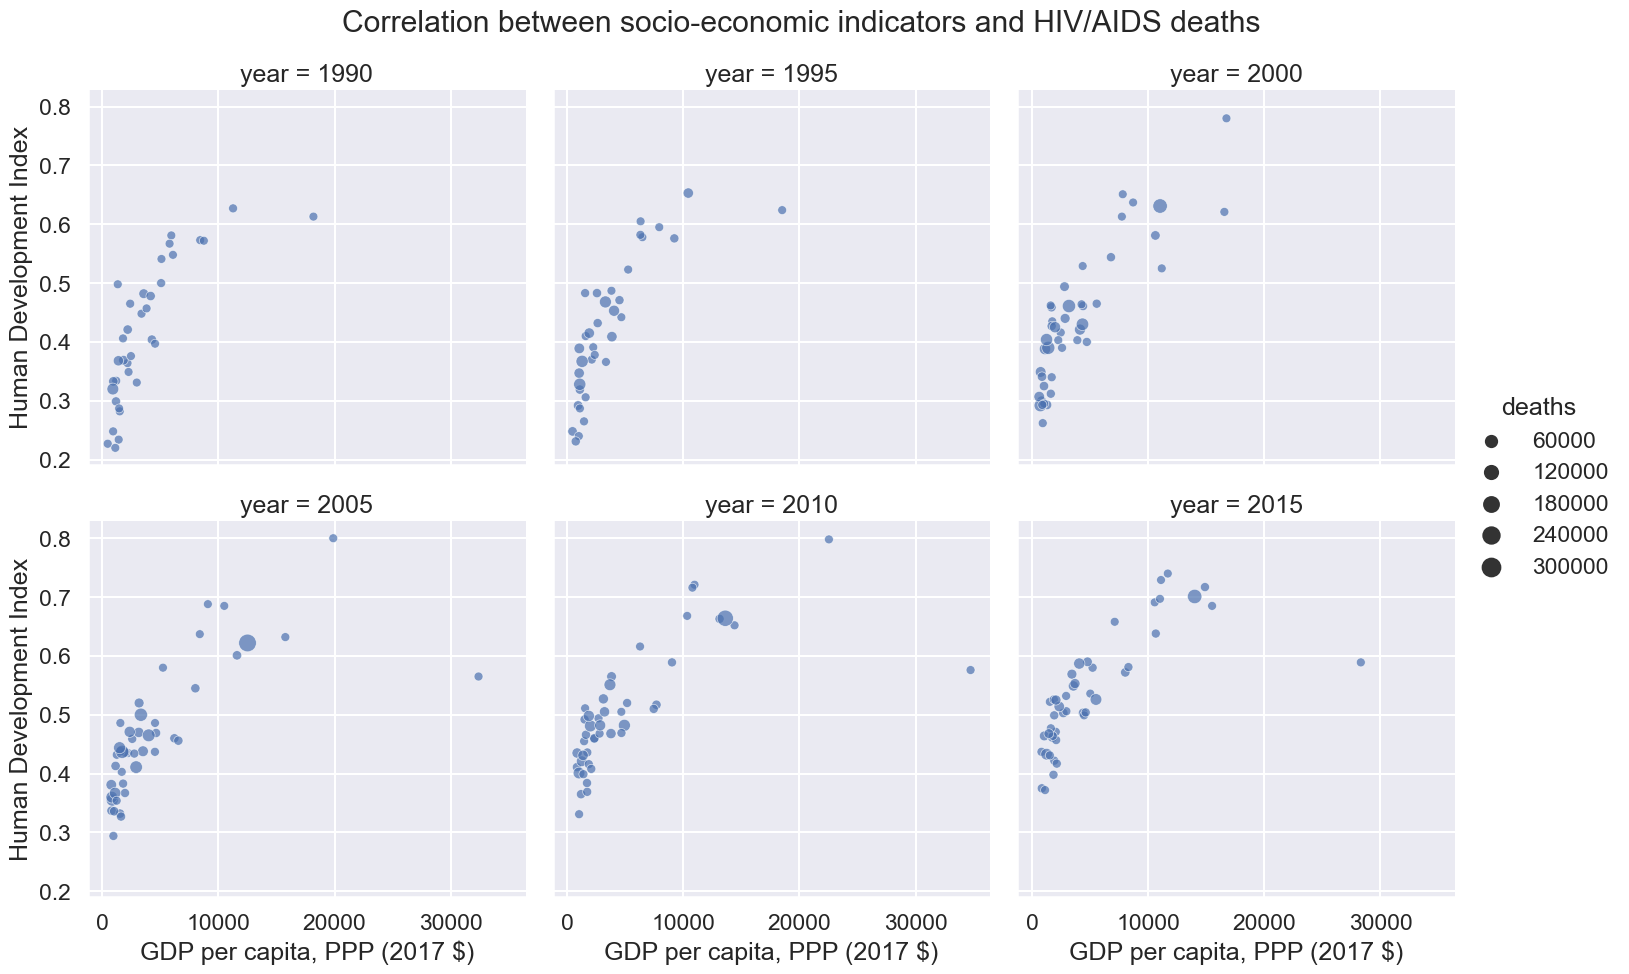

In [133]:
years = [1990, 1995, 2000, 2005, 2010, 2015]
graph_df = graph_df[graph_df['year'].isin(years)]

# Improve readability
sns.set('talk')

g = sns.relplot(x='gdp_per_capita', y='value', data=graph_df,
               size='deaths', alpha=0.7, kind='scatter',
               col='year', col_wrap=3)

g.fig.subplots_adjust(top=.9)
g.fig.suptitle('Correlation between socio-economic indicators and HIV/AIDS deaths')
g.set(xlabel='GDP per capita, PPP (2017 $)', ylabel='Human Development Index')

plt.show()

As seen in the data, less wealthy and underdeveloped countries face higher HIV/AIDS death rates for as long as data has been available. This can be observed in the data as larger data points (higher death rates) are often concentrated toward the bottom-left of the graph where poorer, underdeveloped countries lie.

On an unrelated note, the overall HDI of the entire population of countries has also shifted up over the years, indicating that these African countries have experienced development over the time period studied. For example, there are a ton of countries with an HDI of roughly 0.2 in the '90s, but no country has such a low value in the lower three years. The jump in HDI is especially visible in the 2010 and 2015 data.